In [ ]:
# Tips to run in Colab
# set the runtime to a GPU instance. (runtime > change runtime type > GPU)
# Uncomment following lines to set up dependencies in Colab Server

# ! pip install pycuda
# ! git clone https://github.com/idigitopia/BigMDP.git 
# import os
# os.chdir("BigMDP")
# ! pip install -e . 
# os.chdir("examples")

In [1]:
import os
# import plotly.graph_objects as go
from tqdm import tqdm
from gym import envs
import argparse
import numpy as np
from bigmdp.data.buffer import StandardBuffer,ReplayBuffer, gather_data_in_buffer, get_iter_indexes
from bigmdp.mdp.MDP_GPU import FullMDP
from bigmdp.utils.utils_eval import evaluate_on_env
from bigmdp.mdp.agent import SimpleAgent
from copy import deepcopy as cpy
from os import path
from arg_def import * 
import gym
from sklearn.neighbors import KDTree
from IPython import display
import torch
import time
import copy
import pandas as pd

In [2]:
parser, ArgumentDict = get_argument_parser()
options = "--env_name CartPole-v0 --MAX_S_COUNT 100000 --MAX_NS_COUNT 5 --mdp_build_k 5 --policy_k 11 --normalize_by_distance"
args = parser.parse_args(options.split(" "))

for title, arg_names in ArgumentDict.items():
    print_args(args, to_show_args=arg_names, title = title)

##################################################    envArgs    ##################################################
env_name                       : CartPole-v0                    seed                           : 4444
###################################################################################################################
##################################################    mdpBuildArgs    ##################################################
unknown_transition_reward      : -1000                          rmax_reward                    : 10000
balanced_exploration           : 0                              rmax_threshold                 : 2
MAX_S_COUNT                    : 100000                         def_device                     : GPU
fill_with                      : 0Q_src-KNN                     mdp_build_k                    : 5
knn_delta                      : 1e-08                          penalty_type                   : linear
penalty_beta                   : 1     

In [3]:
env = gym.make(args.env_name)

In [4]:
empty_buffer = ReplayBuffer(state_dim = env.observation_space.shape[0],
                           is_atari= False, 
                           atari_preprocessing= None, 
                           batch_size=32, 
                           buffer_size=20000,
                           device="cpu")

In [5]:
class DummyNet():
    def __init__(self, sim, add_noise=False):
        self.simulator = sim

    def encode_single(self, o):
        return tuple(o)

    def encode_batch(self, o_batch):
        return [tuple(o) for o in o_batch]

    def predict_single_transition(self, o, a):
        assert False, "Not Implemented Error"

    def predict_batch_transition(self, o_batch, a_batch):
        assert False, "Not Implemented Error"

In [6]:
empty_MDP = FullMDP(A= list(range(env.action_space.n)),
                ur=args.unknown_transition_reward,
                vi_params={"gamma":  args.gamma,
                           "slip_prob": args.slip_probability,
                           "rmax_reward": args.rmax_reward,
                           "rmax_thres": args.rmax_threshold,
                           "balanced_explr": args.balanced_exploration,
                          "rmin":-1000},
                knn_delta=args.knn_delta,
                MAX_S_COUNT=args.MAX_S_COUNT,
                MAX_NS_COUNT=args.MAX_NS_COUNT,
                default_mode=args.def_device)

In [7]:
newAgent =  SimpleAgent(mdp_T= cpy(empty_MDP), net = DummyNet(None), fill_with = args.fill_with,
                       mdp_build_k = args.mdp_build_k, plcy_k = args.policy_k[0],  
                       kNN_on_sa = args.smooth_with_seen, soft_at_plcy = args.soft_q, 
                       normalize_by_distance= args.normalize_by_distance,
                       penalty_type=args.penalty_type, penalty_beta = args.penalty_beta,abstraction_flag=False)

In [8]:
eval_reward_data = pd.DataFrame.from_dict({"Epiodes":[],"Performance":[]})

for seed in [0,2,4]:
    myAgent =  cpy(newAgent)
    print("\n\n\n", "#"*30 , f"\tSeed {seed} Run\t","#"*30 , "\n" )
    for i in range(1,61):
        train_buffer, info = gather_data_in_buffer(cpy(empty_buffer), env,policy = myAgent.policies["eps_optimal"] if i>1 else myAgent.policies["random"], episode_count=5, frame_count=1000)
        myAgent.build_mdp(train_buffer, verbose= False)
        
        if i%4==0 or i == 1:
            eval_reward = evaluate_on_env(env,myAgent.policies["optimal"], eps_count=10,progress_bar=True)[0]
            print("#"*20 + f"\t Episode: {i*5}, Size of MDP:{np.sum(myAgent.mdp_T.filled_mask)}, Appended transitions:{len(train_buffer)}, Eval Reward:{eval_reward}\t" + "#"*20)
            eval_reward_data.loc[len(eval_reward_data)] = (i*5,eval_reward)
        


Average Reward of collected trajectories:21.2


100%|██████████| 50/50 [00:01<00:00, 47.86it/s]


####################	 Episode: 5, Size of MDP:108, Length of Train Buffer:105, Eval Reward:68.72	####################
Average Reward of collected trajectories:81.0
Average Reward of collected trajectories:68.2
Average Reward of collected trajectories:60.4


100%|██████████| 50/50 [00:01<00:00, 40.54it/s]


####################	 Episode: 20, Size of MDP:1156, Length of Train Buffer:301, Eval Reward:78.36	####################
Average Reward of collected trajectories:83.6
Average Reward of collected trajectories:96.6
Average Reward of collected trajectories:103.4
Average Reward of collected trajectories:135.8


100%|██████████| 50/50 [00:02<00:00, 19.15it/s]


####################	 Episode: 40, Size of MDP:3254, Length of Train Buffer:678, Eval Reward:172.52	####################
Average Reward of collected trajectories:155.0
Average Reward of collected trajectories:156.2
Average Reward of collected trajectories:158.2
Average Reward of collected trajectories:132.4


100%|██████████| 50/50 [00:02<00:00, 19.79it/s]


####################	 Episode: 60, Size of MDP:6266, Length of Train Buffer:661, Eval Reward:164.96	####################
Average Reward of collected trajectories:138.8
Average Reward of collected trajectories:152.0
Average Reward of collected trajectories:184.4
Average Reward of collected trajectories:173.4


100%|██████████| 50/50 [00:02<00:00, 17.00it/s]


####################	 Episode: 80, Size of MDP:9515, Length of Train Buffer:866, Eval Reward:183.14	####################
Average Reward of collected trajectories:172.0
Average Reward of collected trajectories:169.4
Average Reward of collected trajectories:178.4
Average Reward of collected trajectories:185.6


100%|██████████| 50/50 [00:02<00:00, 16.77it/s]


####################	 Episode: 100, Size of MDP:13048, Length of Train Buffer:927, Eval Reward:188.6	####################
Average Reward of collected trajectories:183.0
Average Reward of collected trajectories:188.8
Average Reward of collected trajectories:155.6
Average Reward of collected trajectories:181.4


100%|██████████| 50/50 [00:02<00:00, 17.37it/s]


####################	 Episode: 120, Size of MDP:16601, Length of Train Buffer:906, Eval Reward:187.68	####################
Average Reward of collected trajectories:176.2
Average Reward of collected trajectories:148.6
Average Reward of collected trajectories:181.6
Average Reward of collected trajectories:156.4


100%|██████████| 50/50 [00:02<00:00, 16.67it/s]


####################	 Episode: 140, Size of MDP:19919, Length of Train Buffer:781, Eval Reward:190.5	####################
Average Reward of collected trajectories:194.6
Average Reward of collected trajectories:186.6
Average Reward of collected trajectories:181.2
Average Reward of collected trajectories:165.0


100%|██████████| 50/50 [00:03<00:00, 16.05it/s]


####################	 Episode: 160, Size of MDP:23565, Length of Train Buffer:824, Eval Reward:192.38	####################
Average Reward of collected trajectories:170.6
Average Reward of collected trajectories:187.2
Average Reward of collected trajectories:196.4
Average Reward of collected trajectories:192.2


100%|██████████| 50/50 [00:02<00:00, 16.81it/s]


####################	 Episode: 180, Size of MDP:27306, Length of Train Buffer:960, Eval Reward:189.52	####################
Average Reward of collected trajectories:195.0
Average Reward of collected trajectories:174.6
Average Reward of collected trajectories:181.8
Average Reward of collected trajectories:185.6


100%|██████████| 50/50 [00:03<00:00, 16.23it/s]


####################	 Episode: 200, Size of MDP:30999, Length of Train Buffer:927, Eval Reward:197.04	####################
Average Reward of collected trajectories:200.0
Average Reward of collected trajectories:195.6
Average Reward of collected trajectories:198.8
Average Reward of collected trajectories:198.8


100%|██████████| 50/50 [00:03<00:00, 16.30it/s]


####################	 Episode: 220, Size of MDP:34978, Length of Train Buffer:993, Eval Reward:196.38	####################
Average Reward of collected trajectories:175.0
Average Reward of collected trajectories:160.6
Average Reward of collected trajectories:200.0
Average Reward of collected trajectories:169.0


100%|██████████| 50/50 [00:03<00:00, 16.43it/s]


####################	 Episode: 240, Size of MDP:38513, Length of Train Buffer:844, Eval Reward:197.44	####################
Average Reward of collected trajectories:194.8
Average Reward of collected trajectories:191.2
Average Reward of collected trajectories:200.0
Average Reward of collected trajectories:193.6


100%|██████████| 50/50 [00:03<00:00, 16.17it/s]


####################	 Episode: 260, Size of MDP:42424, Length of Train Buffer:967, Eval Reward:197.68	####################
Average Reward of collected trajectories:196.8
Average Reward of collected trajectories:200.0
Average Reward of collected trajectories:185.0
Average Reward of collected trajectories:198.0


100%|██████████| 50/50 [00:04<00:00, 11.19it/s]


####################	 Episode: 280, Size of MDP:46336, Length of Train Buffer:989, Eval Reward:198.28	####################
Average Reward of collected trajectories:163.6
Average Reward of collected trajectories:192.0
Average Reward of collected trajectories:194.4
Average Reward of collected trajectories:197.4


100%|██████████| 50/50 [00:03<00:00, 15.64it/s]


####################	 Episode: 300, Size of MDP:50087, Length of Train Buffer:986, Eval Reward:198.48	####################
Average Reward of collected trajectories:20.6


100%|██████████| 50/50 [00:00<00:00, 65.61it/s]


####################	 Episode: 5, Size of MDP:105, Length of Train Buffer:102, Eval Reward:48.58	####################
Average Reward of collected trajectories:45.2
Average Reward of collected trajectories:38.6
Average Reward of collected trajectories:145.2


100%|██████████| 50/50 [00:02<00:00, 22.20it/s]


####################	 Episode: 20, Size of MDP:1250, Length of Train Buffer:725, Eval Reward:139.48	####################
Average Reward of collected trajectories:101.4
Average Reward of collected trajectories:110.0
Average Reward of collected trajectories:104.4
Average Reward of collected trajectories:150.4


100%|██████████| 50/50 [00:03<00:00, 16.65it/s]


####################	 Episode: 40, Size of MDP:3582, Length of Train Buffer:751, Eval Reward:184.38	####################
Average Reward of collected trajectories:173.6
Average Reward of collected trajectories:199.4
Average Reward of collected trajectories:197.6
Average Reward of collected trajectories:164.2


100%|██████████| 50/50 [00:03<00:00, 15.27it/s]


####################	 Episode: 60, Size of MDP:7265, Length of Train Buffer:820, Eval Reward:200.0	####################
Average Reward of collected trajectories:172.4
Average Reward of collected trajectories:187.4
Average Reward of collected trajectories:200.0
Average Reward of collected trajectories:198.4


100%|██████████| 50/50 [00:03<00:00, 15.72it/s]


####################	 Episode: 80, Size of MDP:11069, Length of Train Buffer:991, Eval Reward:197.28	####################
Average Reward of collected trajectories:179.2
Average Reward of collected trajectories:190.6
Average Reward of collected trajectories:181.6
Average Reward of collected trajectories:200.0


100%|██████████| 50/50 [00:03<00:00, 15.77it/s]


####################	 Episode: 100, Size of MDP:14838, Length of Train Buffer:999, Eval Reward:199.98	####################
Average Reward of collected trajectories:196.6
Average Reward of collected trajectories:199.2
Average Reward of collected trajectories:184.0
Average Reward of collected trajectories:188.8


100%|██████████| 50/50 [00:03<00:00, 15.88it/s]


####################	 Episode: 120, Size of MDP:18693, Length of Train Buffer:943, Eval Reward:194.46	####################
Average Reward of collected trajectories:184.6
Average Reward of collected trajectories:191.8
Average Reward of collected trajectories:200.0
Average Reward of collected trajectories:200.0


100%|██████████| 50/50 [00:03<00:00, 15.77it/s]


####################	 Episode: 140, Size of MDP:22589, Length of Train Buffer:999, Eval Reward:197.98	####################
Average Reward of collected trajectories:188.0
Average Reward of collected trajectories:200.0
Average Reward of collected trajectories:195.8
Average Reward of collected trajectories:188.6


100%|██████████| 50/50 [00:03<00:00, 15.03it/s]


####################	 Episode: 160, Size of MDP:26463, Length of Train Buffer:942, Eval Reward:199.86	####################
Average Reward of collected trajectories:200.0
Average Reward of collected trajectories:200.0
Average Reward of collected trajectories:200.0
Average Reward of collected trajectories:200.0


100%|██████████| 50/50 [00:03<00:00, 15.61it/s]


####################	 Episode: 180, Size of MDP:30479, Length of Train Buffer:999, Eval Reward:199.88	####################
Average Reward of collected trajectories:185.8
Average Reward of collected trajectories:200.0
Average Reward of collected trajectories:198.2
Average Reward of collected trajectories:200.0


100%|██████████| 50/50 [00:03<00:00, 15.21it/s]


####################	 Episode: 200, Size of MDP:34412, Length of Train Buffer:999, Eval Reward:200.0	####################
Average Reward of collected trajectories:188.2
Average Reward of collected trajectories:188.6
Average Reward of collected trajectories:200.0
Average Reward of collected trajectories:194.0


100%|██████████| 50/50 [00:03<00:00, 14.91it/s]


####################	 Episode: 220, Size of MDP:38278, Length of Train Buffer:969, Eval Reward:200.0	####################
Average Reward of collected trajectories:200.0
Average Reward of collected trajectories:188.6
Average Reward of collected trajectories:200.0
Average Reward of collected trajectories:200.0


100%|██████████| 50/50 [00:03<00:00, 14.67it/s]


####################	 Episode: 240, Size of MDP:42236, Length of Train Buffer:999, Eval Reward:199.8	####################
Average Reward of collected trajectories:200.0
Average Reward of collected trajectories:197.2
Average Reward of collected trajectories:200.0
Average Reward of collected trajectories:197.8


100%|██████████| 50/50 [00:03<00:00, 15.30it/s]


####################	 Episode: 260, Size of MDP:46225, Length of Train Buffer:988, Eval Reward:198.2	####################
Average Reward of collected trajectories:200.0
Average Reward of collected trajectories:200.0
Average Reward of collected trajectories:200.0
Average Reward of collected trajectories:188.4


100%|██████████| 50/50 [00:03<00:00, 15.29it/s]


####################	 Episode: 280, Size of MDP:50183, Length of Train Buffer:941, Eval Reward:195.88	####################
Average Reward of collected trajectories:193.2
Average Reward of collected trajectories:200.0
Average Reward of collected trajectories:200.0
Average Reward of collected trajectories:200.0


100%|██████████| 50/50 [00:03<00:00, 16.12it/s]


####################	 Episode: 300, Size of MDP:54165, Length of Train Buffer:999, Eval Reward:200.0	####################
Average Reward of collected trajectories:27.6


100%|██████████| 50/50 [00:01<00:00, 40.73it/s]


####################	 Episode: 5, Size of MDP:140, Length of Train Buffer:137, Eval Reward:80.7	####################
Average Reward of collected trajectories:56.0
Average Reward of collected trajectories:132.0
Average Reward of collected trajectories:136.8


100%|██████████| 50/50 [00:02<00:00, 20.97it/s]


####################	 Episode: 20, Size of MDP:1766, Length of Train Buffer:683, Eval Reward:159.4	####################
Average Reward of collected trajectories:131.0
Average Reward of collected trajectories:149.2
Average Reward of collected trajectories:155.0
Average Reward of collected trajectories:131.2


100%|██████████| 50/50 [00:02<00:00, 19.52it/s]


####################	 Episode: 40, Size of MDP:4602, Length of Train Buffer:655, Eval Reward:172.52	####################
Average Reward of collected trajectories:145.8
Average Reward of collected trajectories:157.2
Average Reward of collected trajectories:155.4
Average Reward of collected trajectories:159.2


100%|██████████| 50/50 [00:03<00:00, 15.53it/s]


####################	 Episode: 60, Size of MDP:7694, Length of Train Buffer:795, Eval Reward:190.62	####################
Average Reward of collected trajectories:121.2
Average Reward of collected trajectories:150.0
Average Reward of collected trajectories:190.2
Average Reward of collected trajectories:176.6


100%|██████████| 50/50 [00:03<00:00, 15.85it/s]


####################	 Episode: 80, Size of MDP:10889, Length of Train Buffer:882, Eval Reward:192.5	####################
Average Reward of collected trajectories:200.0
Average Reward of collected trajectories:164.2
Average Reward of collected trajectories:198.0
Average Reward of collected trajectories:186.8


100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


####################	 Episode: 100, Size of MDP:14644, Length of Train Buffer:933, Eval Reward:192.44	####################
Average Reward of collected trajectories:184.6
Average Reward of collected trajectories:195.4
Average Reward of collected trajectories:161.2
Average Reward of collected trajectories:179.4


100%|██████████| 50/50 [00:03<00:00, 15.79it/s]


####################	 Episode: 120, Size of MDP:18259, Length of Train Buffer:896, Eval Reward:194.62	####################
Average Reward of collected trajectories:151.8
Average Reward of collected trajectories:185.4
Average Reward of collected trajectories:196.6
Average Reward of collected trajectories:189.6


100%|██████████| 50/50 [00:03<00:00, 15.90it/s]


####################	 Episode: 140, Size of MDP:21886, Length of Train Buffer:947, Eval Reward:194.14	####################
Average Reward of collected trajectories:198.4
Average Reward of collected trajectories:162.4
Average Reward of collected trajectories:140.4
Average Reward of collected trajectories:177.8


100%|██████████| 50/50 [00:03<00:00, 15.82it/s]


####################	 Episode: 160, Size of MDP:25288, Length of Train Buffer:888, Eval Reward:193.38	####################
Average Reward of collected trajectories:193.0
Average Reward of collected trajectories:195.2
Average Reward of collected trajectories:165.2
Average Reward of collected trajectories:197.6


100%|██████████| 50/50 [00:03<00:00, 15.90it/s]


####################	 Episode: 180, Size of MDP:29055, Length of Train Buffer:987, Eval Reward:191.42	####################
Average Reward of collected trajectories:181.2
Average Reward of collected trajectories:194.0
Average Reward of collected trajectories:200.0
Average Reward of collected trajectories:199.8


100%|██████████| 50/50 [00:03<00:00, 15.27it/s]


####################	 Episode: 200, Size of MDP:32941, Length of Train Buffer:998, Eval Reward:195.62	####################
Average Reward of collected trajectories:178.2
Average Reward of collected trajectories:106.6
Average Reward of collected trajectories:200.0
Average Reward of collected trajectories:194.6


100%|██████████| 50/50 [00:03<00:00, 15.35it/s]


####################	 Episode: 220, Size of MDP:36346, Length of Train Buffer:972, Eval Reward:193.02	####################
Average Reward of collected trajectories:200.0
Average Reward of collected trajectories:189.4
Average Reward of collected trajectories:200.0
Average Reward of collected trajectories:188.8


100%|██████████| 50/50 [00:03<00:00, 14.32it/s]


####################	 Episode: 240, Size of MDP:40251, Length of Train Buffer:943, Eval Reward:197.88	####################
Average Reward of collected trajectories:187.2
Average Reward of collected trajectories:190.2
Average Reward of collected trajectories:178.6
Average Reward of collected trajectories:191.4


100%|██████████| 50/50 [00:03<00:00, 14.46it/s]


####################	 Episode: 260, Size of MDP:44001, Length of Train Buffer:956, Eval Reward:197.12	####################
Average Reward of collected trajectories:200.0
Average Reward of collected trajectories:158.4
Average Reward of collected trajectories:197.2
Average Reward of collected trajectories:181.4


100%|██████████| 50/50 [00:03<00:00, 12.71it/s]


####################	 Episode: 280, Size of MDP:47698, Length of Train Buffer:906, Eval Reward:197.64	####################
Average Reward of collected trajectories:187.0
Average Reward of collected trajectories:200.0
Average Reward of collected trajectories:196.8
Average Reward of collected trajectories:173.4


100%|██████████| 50/50 [00:03<00:00, 15.22it/s]

####################	 Episode: 300, Size of MDP:51496, Length of Train Buffer:866, Eval Reward:197.24	####################


In [11]:
import seaborn as sns

[Text(0.5, 1.0, 'CartPole Performance , Averaged over 3 Seeds \n solved every 5 episodes, exploration: eps_optimal policy')]

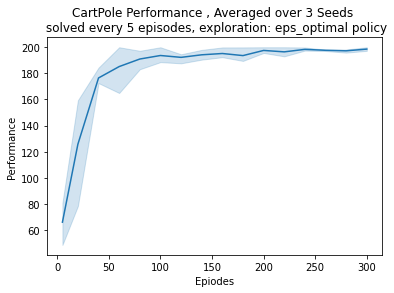

In [14]:
ax = sns.lineplot(data=eval_reward_data, x = "Epiodes", y = "Performance")
ax.set(title='CartPole Performance , Averaged over 3 Seeds \n solved every 5 episodes, exploration: eps_optimal policy')
